I wrote this kernel to mess around with the sketch data and share my experience so far.  After exploring the website and the data, I'll use a very basic CNN to classify sketches. This model gets 0.60 on the Public LB when run with 6000 recognized images per class.

## Quick, Draw
Ok - I have to say this is kind of a fun thing. You go to the [Quick Draw](https://quickdraw.withgoogle.com/#)  website and agree to sketch several common objects. The host then gives you the object labels one by one, and you have 20 seconds to draw each one. If the AI guesses your sketch (that is, associates it with training set items of the same label) you get a check mark and move on. At the end you get something like this:

<img src="https://s3.amazonaws.com/nonwebstorage/Screenshot+from+2018-09-26+22-44-21.png" alt="drawing1" width="600"/>
  
<p><br></p>
Notice that it didn't like my bird. Apparently it looked more like a dragon or a diving board(??) or a mosquito.  They're nice enough to show you how other people draw birds so you maybe learn how to draw better.
<img src="https://s3.amazonaws.com/nonwebstorage/Screenshot+from+2018-09-26+22-45-21.png" alt="drawing1" width="600"/>

## Training Images
We can look at a few sketches and then see what the training data contains overall. I'll use an adaptation of Inversion's 'Getting Started' kernel.

In [1]:
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline

Here's what the training data looks like. This data frame is actually a concatenation of two rows from each of 6 csv files in the training set.

In [2]:
fnames = glob('../input/train_simplified/*.csv')
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:6]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[91, 73, 53, 31, 26, 24], [255, 251, 235, 18...",5940792512217088,True,2017-03-22 17:41:18.806040,stethoscope
1,US,"[[[17, 5, 0, 0, 18, 43, 74, 95, 135, 139, 142,...",5817564116549632,True,2017-01-26 14:30:44.006860,stethoscope
2,US,"[[[62, 66, 91, 121, 159, 200, 218, 232, 246, 2...",6120310522773504,True,2017-01-31 15:39:43.366540,fan
3,US,"[[[81, 65, 54, 28, 3, 0, 5, 20, 39, 74, 125, 1...",6636873587884032,True,2017-01-23 00:46:51.549530,fan
4,US,"[[[136, 119, 71, 53, 9, 0, 21, 64, 67, 65, 75,...",5795934136958976,True,2017-03-26 18:11:00.449190,dragon
5,BE,"[[[5, 30, 40, 73, 83, 87, 87, 70, 44, 36, 6, 2...",5715354980450304,True,2017-03-28 21:42:33.092960,dragon
6,AT,"[[[15, 39, 87, 178, 244], [126, 104, 83, 60, 5...",5505601176076288,True,2017-03-09 15:23:32.521310,bridge
7,DK,"[[[35, 90, 137, 164], [119, 100, 100, 96]], [[...",6156662199025664,True,2017-03-28 19:25:22.017040,bridge
8,US,"[[[0, 23, 37, 51, 93, 122, 154, 163, 218, 239,...",6070764249808896,True,2017-01-27 18:23:51.389140,river
9,AU,"[[[170, 172, 0, 8, 16, 11], [4, 7, 9, 19, 23, ...",6199475305447424,True,2017-03-24 21:00:26.802270,river


And here are some nice sketches...

In [3]:
evens = range(0,11,2)
odds = range(1,12, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


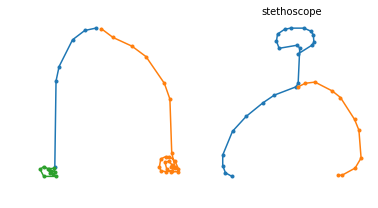

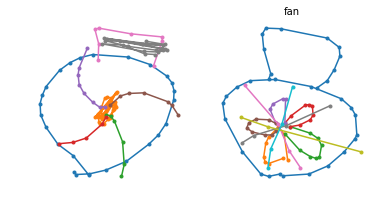

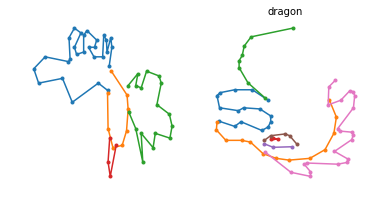

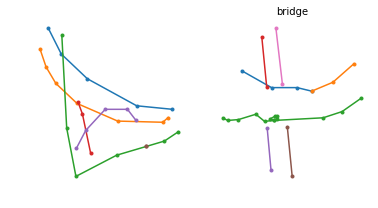

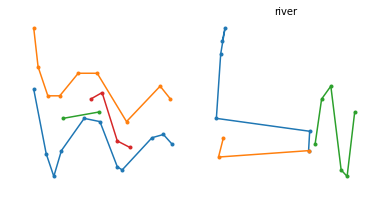

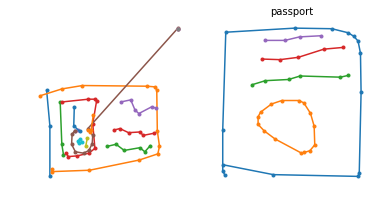

In [4]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)

    plt.show()  

## The Quick, Draw Data Repository
There is a direct data source outside of Kaggle that seems pretty useful. The main link is a [GitHub Repository](https://github.com/googlecreativelab/quickdraw-dataset) that leads to the data in several formats, including Numpy bitmap files. Each file in the dataset covers a specific type of sketch and is in the shape of a long 1d array. Here are a few.

Update: The test set for this project doesn't have premade files in the numpy bitmap format. When you apply your model to test arrays converted from matplotlib, there is a loss due to the different conversion process. The best results for an image-based model are had by using the same processing for train and test (no surprise there I guess). So I'd say these are good for exploration but consider the other files for better results.

In [5]:
# # commented out to save memory
# import urllib

# LABELS = np.array(['baseball', 'bowtie', 'clock', 'hand', 'hat'])
# for b in LABELS:
#     url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{}.npy".format(b)
#     urllib.request.urlretrieve(url, "{}.npy".format(b))
#     nb = np.load("{}.npy".format(b))
#     print("\n Class '{0}' has {1} examples of {2}x{2} images".format(b, nb.shape[0], int(nb.shape[1]**0.5)))

## Convolutional Neural Network (CNN)
Next we'll build an image classifier. There are some resources in the repository I mentioned earlier showing how people have used the data. One of those resources is a CNN just like what you see here. 

The biggest usage of resources seems to be converting the drawings to images. You can stick with a stroke-based model or go down the conversion path. Going that way requires watching data usage and managing space limits - deep learning on Kaggle can be like building a ship in a bottle:) 

UPDATE: I'll be experimenting with a separate kernel to use a fit_generator like in Beluga's kernel and others. This kernel has the most I could squeeze into memory with simple fit and predict.

In [6]:
%reset -f 

In [7]:
#%% import
import os
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [8]:
#%% set label dictionary and params
classfiles = os.listdir('../input/train_simplified/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 340    #340 max 
imheight, imwidth = 32, 32  
ims_per_class = 2000  #max?

In [9]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
train_grand = []
class_paths = glob('../input/train_simplified/*.csv')
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 340/340 [10:46<00:00,  1.90s/it]


In [10]:
# memory-friendly alternative to train_test_split?
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(612000, 340) 
 (612000, 32, 32, 1) 
 (68000, 340) 
 (68000, 32, 32, 1)


Here's the architecture for the CNN. It's fairly simple compared to what else you can do.

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 680)               2785960   
__________

In [13]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

model.fit(x=X_train, y=y_train,
          batch_size = 4096,
          epochs = 22,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          verbose = 1)

Train on 612000 samples, validate on 68000 samples
Epoch 1/22
612000/612000 [==============================] - 42s 69us/step - loss: 3.7004 - acc: 0.2087 - top_3_accuracy: 0.3685 - val_loss: 2.8358 - val_acc: 0.3676 - val_top_3_accuracy: 0.5639
Epoch 2/22
612000/612000 [==============================] - 40s 65us/step - loss: 2.9579 - acc: 0.3280 - top_3_accuracy: 0.5233 - val_loss: 2.4159 - val_acc: 0.4366 - val_top_3_accuracy: 0.6428
Epoch 3/22
612000/612000 [==============================] - 40s 65us/step - loss: 2.6603 - acc: 0.3795 - top_3_accuracy: 0.5838 - val_loss: 2.2415 - val_acc: 0.4680 - val_top_3_accuracy: 0.6752
Epoch 4/22
612000/612000 [==============================] - 40s 66us/step - loss: 2.4935 - acc: 0.4090 - top_3_accuracy: 0.6160 - val_loss: 2.1165 - val_acc: 0.4918 - val_top_3_accuracy: 0.6994
Epoch 5/22
612000/612000 [==============================] - 40s 66us/step - loss: 2.3849 - acc: 0.4292 - top_3_accuracy: 0.6383 - val_loss: 2.0346 - val_acc: 0.5062 - val_to

## Predicting on the Test data
The CNN does OK on the validation data, even with a basic model and limited training data. Let's generate predictions on the test set and submit.

In [14]:
#%% get test set
ttvlist = []
reader = pd.read_csv('../input/test_simplified.csv', index_col=['key_id'],
    chunksize=2048)
for chunk in tqdm(reader, total=55):
    imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    testarray = np.array(imagebag.compute())
    testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
    testpreds = model.predict(testarray, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
    ttvlist.append(ttvs)
    
ttvarray = np.concatenate(ttvlist)

100%|██████████| 55/55 [02:16<00:00,  2.39s/it]


In [ ]:
preds_df = pd.DataFrame({'first': ttvarray[:,0], 'second': ttvarray[:,1], 'third': ttvarray[:,2]})
preds_df = preds_df.replace(numstonames)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv('../input/sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('subcnn_small.csv')
sub.head()

 A full version with 6000 images per class at 28x28 gets just under 0.60 on the public LB.  

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not 
    x.startswith('_') and x not in sys.modules and x 
    not in ipython_vars], key=lambda x: x[1], reverse=True)